![National Health and Nutrition Examination Survey](https://www.cdc.gov/nchs/nhanes/wcms-inc/VP4_935_NHANES.png)

# NHANES k-means Clustering Analysis

**Objective:** Identify clusters of survey respondents in the NHANES dataset.

**Data:** NHANES 2017-March 2020 Pre-Pandemic Questionnaire Data

**Model Type:** k-means clustering (unsupervised machine learning)

**Tools/Libraries:** Pandas, scikit-Learn, Matplotlib, Seaborn
<br><br>

## Summary
For this project, my goal was to build a k-means model that clusters individuals based on medical and demographic data. The NHANES is a great data source for this because it is publicly available and captures many aspects of survey participants' health. This includes demographics, physical exam and blood test results, dietary observations, and lifestyle questionnaires. This dataset also works well with a k-means model because much of the data consists of continuous numeric values, and many of the categorical variables are reported as numeric values with an ordinal logic.

# Table of Contents
1. Dataset
2. Data Wrangling
    - Exploratory Data Analysis
    - Imputation
    - Feature Engineering
    - Scaling
3. k-means Model
    - Define Functions
    - Perform clustering

# Dataset

The CDC publishes the National Health and Nutrition Examination Survey (NHANES) data on the [NHANES website](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?Cycle=2017-2020), usually every two years. For this project, I used the 2017 - March 2020 dataset, as it was the most recent data available. For each reporting time period, the dataset is split into six categories (Demographic, Dietary, Examination, Laboratory, Questionnaire, and Limited Access Data), which are further split into subcategories.

For my clustering analysis, I used the following data files (available for download at the NHANES website):
- P_DEMO.XPT (demographics)
-P_BMX.XPT (body measures)
-P_BPXO.XPT (blood pressure)
-P_CBC.XPT (complete blood count)
-P_HDL.XPT (cholesterol (HDL))
-P_TRIGLY.XPT (cholesterol (LDL) + triglycerides)
-P_DR1TOT.XPT (daily nutrient intake)
-P_ALQ.XPT (alcohol use)
-P_SMQ.XPT (smoking/cigarette use)
-P_PAQ.XPT (physical activity)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Mount google drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading data files into dataframe

First, I loaded the data files into separate Pandas dataframes and then merged them into one combined dataframe, retaining only the columns that I wanted to keep as potential features for my cluster analysis. I intended to only include survey respondents that were present in all my data files, so I used inner merges.

In [3]:
# Load data files into dataframes
file_path = '/content/drive/My Drive/Colab Notebooks/Datasets/NHANES/'
demo = pd.read_sas(file_path + '2017 - Mar 2020/P_DEMO.XPT') # demographics
bm = pd.read_sas(file_path + '2017 - Mar 2020/P_BMX.XPT') # body measures
bp = pd.read_sas(file_path + '2017 - Mar 2020/P_BPXO.XPT') #blood pressure
cbc = pd.read_sas(file_path + '2017 - Mar 2020/P_CBC.XPT') # complete blood count
hdl = pd.read_sas(file_path + '2017 - Mar 2020/P_HDL.XPT') # cholesterol (HDL)
ldl_trigly = pd.read_sas(file_path + '2017 - Mar 2020/P_TRIGLY.XPT') # cholesterol (LDL) + triglycerides
nutr = pd.read_sas(file_path + '2017 - Mar 2020/P_DR1TOT.XPT') # daily nutrient intake
alc = pd.read_sas(file_path + '2017 - Mar 2020/P_ALQ.XPT') # alcohol use
smoke = pd.read_sas(file_path + '2017 - Mar 2020/P_SMQ.XPT') # cigarette use
phys_act = pd.read_sas(file_path + '2017 - Mar 2020/P_PAQ.XPT') # physical activity

In [4]:
# Merge dataframes on 'SEQN' (survey respondent identifier)
df = demo[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDEDUC2']] # gender, age, race/hispanic origin, income-to-poverty ratio, education level
df = df.merge(bm[['SEQN', 'BMXBMI', 'BMXHT', 'BMXWT']], on='SEQN', how='inner') # BMI, height (cm), weight (kg)
df = df.merge(bp[['SEQN', 'BPXOSY1', 'BPXODI1']], on='SEQN', how='inner') # systolic BP, diastolic BP
df = df.merge(cbc[['SEQN', 'LBXWBCSI', 'LBXRBCSI', 'LBXPLTSI']], on='SEQN', how='inner') # white blood cell count, red blood cell count, platelet count
df = df.merge(hdl[['SEQN', 'LBDHDD']], on='SEQN', how='inner') # HDL cholesterol (mg/dL)
df = df.merge(ldl_trigly[['SEQN', 'LBDLDL', 'LBXTR']], on='SEQN', how='inner') # LDL cholesterol (mg/dL), triglycerides (mg/dL)
df = df.merge(nutr[['SEQN', 'DR1TNUMF', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TTFAT']], on='SEQN', how='inner') # num. foods reported, calories, protein, carbs, fat
df = df.merge(alc[['SEQN', 'ALQ121', 'ALQ130']], on='SEQN', how='inner') # alcohol consumption frequency, avg. drink per day
df = df.merge(smoke[['SEQN', 'SMQ040']], on='SEQN', how='inner') # cigarette smoking status
df = df.merge(phys_act[['SEQN', 'PAQ610', 'PAQ625', 'PAQ655', 'PAQ670']], on='SEQN', how='inner') # vigorous work days/week, moderate intensity work days/week, vigorous recreation days/week, moderate intensity recreation days/week

# Rename columns
df.columns = ['seqn', 'gender', 'age', 'race', 'poverty_ratio', 'education',
              'bmi', 'height', 'weight',
              'sbp', 'dbp',
              'wbc', 'rbc', 'platelet',
              'hdl',
              'ldl', 'triglyc',
              'food_count', 'kcal', 'protein', 'carb', 'fat',
              'alcohol_freq', 'alcohol_per_day',
              'smoking_status',
              'vigorous_work', 'moderate_work', 'vigorous_rec', 'moderate_rec']

## Dataframe overview

The table below provides descriptions of all columns in my combined dataframe. All the data is represented as numeric values. Keys to categorical variables are provided. While categorical variables are sometimes not easily utilized in k-means models, most of them in this dataframe follow an ordinal logic, making them suitable for the model.<br><br>

| Original Variable Name | Renamed Variable | Definition | Key |
| ----------------- | ---------------- | ---------- | --- |
| SEQN | seqn | Survey respondent identifier |  |
| RIAGENDR | gender | Gender | 1 = Male<br>2 = Female |
| RIDAGEYR | age | Age (years) | 0-79 = Range of ages<br>80 = 80 years or older |
| RIDRETH1 | race | Race/Hispanic origin | 1 = Mexican American<br>2 = Other Hispanic<br>3 = Non-Hispanic White<br>4 = Non-Hispanic Black<br>5 = Other Race - including multi-racial |
| INDFMPIR | poverty_ratio | Ratio of family income to poverty line | 0-4.99 = Range of values<br>5 = Value greater than or equal to 5 |
| DMDEDUC2 | education | Education level (adults 20+) | 1 = Less than 9th grade<br>2 = 9-12th grade (no diploma)<br>3 = High school diploma or equivalent<br>4 = Some college or AA degree<br>5 = College graduate or above<br>7 = Refused<br>9 = Don't know |
| BMXBMI          | bmi      | Body mass index   |    |
| BMXHT           | height                | Height (cm)   |    |
| BMXWT           | weight                | Weight (kg)   |    |
| BPXOSY1         | sbp                   | Systolic blood pressure   |    |
| BPXODI1         | dbp                   | Diastolic blood pressure   |    |
| LBXWBCSI        | wbc       | White blood cell count (1,000 cells/uL)   |    |
| LBXRBCSI        | rbc    | Red blood cell count (million cells/uL)   |    |
| LBXPLTSI        | platelet  | Platelet count (1,000 cells/uL)   |    |
| LBDHDD          | hdl                   | HDL Cholesterol (mg/dL)   |    |
| LBDLDL          | ldl                   | LDL Cholesterol (mg/dL)   |    |
| LBXTR           | triglyc               | Triglyceride (mg/dL)   |    |
| DR1TNUMF     | food_count   | Number of foods/beverages reported (1 day)   |    |
| DR1TKCAL        | kcal      | Calories consumed (kcal) (1 day)   |    |
| DR1TPROT        | protein      | Protein consumed (g) (1 day)   |    |
| DR1TCARB        | carb     | Carbohydrates consumed (g) (1 day)   |    |
| DR1TTFAT        | fat        | Fat consumed (g) (1 day)   |    |
| ALQ121          | alcohol_freq   | Alcohol drinking frequency (past 12 months)   | 0 = Never in the last year<br>1 = Every day<br>2 = Nearly every day<br>3 = 3-4 times per week<br>4 = 2 times per week<br>5 = Once per week<br>6 = 2-3 times per month<br>7 = Once per month<br>8 = 7-11 times in the last year<br>9 = 3-6 times in the last year<br>10 = 1-2 times in the last year<br>77 = Refused<br>99 = Don't know   |
| ALQ130          | alcohol_per_day     | Average number of alcoholic drinks per day (past 12 months)   | 1-14 = Range of values<br>15 = 15 drinks or more<br>777 = Refused<br>999 = Don't know   |
| SMQ040          | smoking_status        | Current smoking status (cigarettes)   | 1 = Every day<br>2 = Some days<br>3 = Not at all<br>7 = Refused<br>9 = Don't know   |
| PAQ610          | vigorous_work         | # days/week of vigorous-intensity activities (occupational)   | 1-7 = Range of values<br>77 = Refused<br>99 = Don't know   |
| PAQ625          | moderate_work         | # days/week of moderate-intensity activities (occupational)   | 1-7 = Range of values<br>77 = Refused<br>99 = Don't know   |
| PAQ655          | vigorous_rec          | # days/week of vigorous-intensity activities (recreational)   | 1-7 = Range of values<br>77 = Refused<br>99 = Don't know   |
| PAQ670          | moderate_rec          | # days/week of moderate-intensity activities (recreational)   | 1-7 = Range of values<br>77 = Refused<br>99 = Don't know   |

In [5]:
# View the first 5 rows of the dataframe
pd.set_option('display.max_columns', None)
df.head()

,seqn,gender,age,race,poverty_ratio,education,bmi,height,weight,sbp,dbp,wbc,rbc,platelet,hdl,ldl,triglyc,food_count,kcal,protein,carb,fat,alcohol_freq,alcohol_per_day,smoking_status,vigorous_work,moderate_work,vigorous_rec,moderate_rec
0,109271.0,1.0,49.0,3.0,NaN,2.0,29.7,182.3,98.8,102.0,65.0,5.5,4.54,254.0,33.0,97.0,84.0,12.0,2310.0,110.62,207.54,113.77,5.397605e-79,NaN,1.0,NaN,2.0,NaN,NaN
1,109274.0,1.0,68.0,5.0,1.20,4.0,30.2,185.3,103.7,138.0,70.0,3.7,4.47,173.0,29.0,49.0,133.0,9.0,2385.0,77.75,305.41,86.42,4.000000e+00,2.0,NaN,7.0,6.0,NaN,3.0
2,109282.0,1.0,76.0,3.0,3.61,5.0,26.6,177.1,83.3,141.0,77.0,4.0,4.16,154.0,43.0,164.0,132.0,16.0,2026.0,58.33,310.87,64.05,5.397605e-79,NaN,3.0,NaN,NaN,NaN,NaN
3,109286.0,2.0,33.0,5.0,1.36,5.0,28.9,158.4,72.6,NaN,NaN,11.1,3.36,321.0,67.0,131.0,192.0,35.0,3146.0,190.98,275.46,141.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,109290.0,2.0,68.0,4.0,5.00,5.0,28.1,161.2,73.0,126.0,62.0,9.4,5.33,289.0,40.0,105.0,102.0,7.0,822.0,30.45,143.44,13.77,5.397605e-79,NaN,NaN,NaN,1.0,NaN,2.0


In [6]:
# Review the dataframe column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4438 entries, 0 to 4437
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seqn             4438 non-null   float64
 1   gender           4438 non-null   float64
 2   age              4438 non-null   float64
 3   race             4438 non-null   float64
 4   poverty_ratio    3808 non-null   float64
 5   education        4252 non-null   float64
 6   bmi              4348 non-null   float64
 7   height           4355 non-null   float64
 8   weight           4360 non-null   float64
 9   sbp              3983 non-null   float64
 10  dbp              3983 non-null   float64
 11  wbc              4236 non-null   float64
 12  rbc              4236 non-null   float64
 13  platelet         4236 non-null   float64
 14  hdl              4111 non-null   float64
 15  ldl              4068 non-null   float64
 16  triglyc          4100 non-null   float64
 17  food_count    

# Data Wrangling

The dataframe included null values, as well as values that represent "Refused" and "Don't know" responses to survey questions.

In some columns, the true value of the nulls could be inferred. I addressed these instances first and then replaced "Refused" and "Don't know" responses with nulls.

(For example, in the 'alcohol_freq' column, nulls represent missing data. However, per the dataset documentation, this question was not asked if the survey respondent indicated in a prior question that they have never drank alcohol. Therefore, it could be inferred that the true value of most of these nulls is 0.)

In [7]:
# Replace null values where their true values can be inferred
null_zero_cols = ['alcohol_freq','smoking_status','vigorous_work','moderate_work','vigorous_rec','moderate_rec']
df[null_zero_cols] = df[null_zero_cols].fillna(0)
df['smoking_status'] = df['smoking_status'].fillna(4)

# Replace 'Refused' and 'Don't know' responses with null values
null_resp_cols = ['education','smoking_status']
df[null_resp_cols] = df[null_resp_cols].replace([7, 9], np.nan)
null_resp_cols = ['alcohol_freq','vigorous_work','moderate_work','vigorous_rec','moderate_rec']
df[null_resp_cols] = df[null_resp_cols].replace([77, 99], np.nan)
df['alcohol_per_day'] = df['alcohol_per_day'].replace([777, 999], np.nan)

In [8]:
# Review df column info again to see how many null values remain
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4438 entries, 0 to 4437
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seqn             4438 non-null   float64
 1   gender           4438 non-null   float64
 2   age              4438 non-null   float64
 3   race             4438 non-null   float64
 4   poverty_ratio    3808 non-null   float64
 5   education        4249 non-null   float64
 6   bmi              4348 non-null   float64
 7   height           4355 non-null   float64
 8   weight           4360 non-null   float64
 9   sbp              3983 non-null   float64
 10  dbp              3983 non-null   float64
 11  wbc              4236 non-null   float64
 12  rbc              4236 non-null   float64
 13  platelet         4236 non-null   float64
 14  hdl              4111 non-null   float64
 15  ldl              4068 non-null   float64
 16  triglyc          4100 non-null   float64
 17  food_count    

In [9]:
# About 35% of the values in 'alcohol_per_day' are still null, so I will drop the column altogether.
df = df.drop(columns=['alcohol_per_day'])

## Exploratory Data Analysis

Before imputing null values, I looked at a statistical summary of the dataframe and generated histrograms for each column. I used the shape of each column's distribution to help decide whether column medians or means should be used for imputation.

In [10]:
# Statistical summary
df.describe()

,seqn,gender,age,race,poverty_ratio,education,bmi,height,weight,sbp,dbp,wbc,rbc,platelet,hdl,ldl,triglyc,food_count,kcal,protein,carb,fat,alcohol_freq,smoking_status,vigorous_work,moderate_work,vigorous_rec,moderate_rec
count,4438.00000,4438.000000,4438.000000,4438.000000,3.808000e+03,4249.000000,4348.000000,4355.000000,4360.000000,3983.000000,3983.000000,4236.000000,4236.000000,4236.000000,4111.000000,4068.000000,4100.000000,4028.000000,4028.000000,4.028000e+03,4028.000000,4.028000e+03,4.438000e+03,4438.000000,4437.000000,4434.000000,4438.000000,4437.000000
mean,117186.32064,1.518026,49.629338,3.265660,2.555622e+00,3.523888,29.812626,166.817979,83.206170,124.079588,74.792368,6.775826,4.747240,242.695703,53.812454,107.777532,108.253659,15.321500,2097.796177,7.859371e+01,242.688078,8.555334e+01,4.093060e+00,0.915277,1.030877,1.825440,0.833484,1.418751
std,4498.47671,0.499731,18.292069,1.224771,1.615405e+00,1.204572,7.720594,10.020358,23.345814,19.803554,11.934562,2.119834,0.517281,64.943072,15.931257,35.537434,93.442882,6.038751,990.401098,4.140951e+01,124.586321,4.762830e+01,3.670953e+00,1.242888,2.001170,2.391564,1.652608,2.043042
min,109271.00000,1.000000,18.000000,1.000000,5.397605e-79,1.000000,14.900000,131.100000,36.700000,66.000000,36.000000,1.900000,2.560000,49.000000,11.000000,7.000000,10.000000,1.000000,3.000000,5.397605e-79,0.020000,5.397605e-79,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,113333.25000,1.000000,34.000000,3.000000,1.180000e+00,3.000000,24.600000,159.300000,66.900000,110.000000,67.000000,5.400000,4.410000,198.000000,42.000000,83.000000,59.000000,11.000000,1406.750000,5.036500e+01,157.927500,5.250000e+01,5.397605e-79,0.000000,0.000000,0.000000,0.000000,0.000000
50%,117247.00000,2.000000,51.000000,3.000000,2.190000e+00,4.000000,28.500000,166.500000,79.800000,121.000000,74.000000,6.500000,4.730000,235.000000,51.000000,104.000000,88.000000,15.000000,1951.000000,7.147000e+01,220.230000,7.717500e+01,4.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,121077.75000,2.000000,64.000000,4.000000,4.080000e+00,4.000000,33.600000,174.000000,95.200000,135.000000,82.000000,7.900000,5.080000,279.000000,62.000000,129.000000,131.000000,19.000000,2628.000000,9.957750e+01,306.592500,1.109400e+02,7.000000e+00,2.000000,1.000000,4.000000,0.000000,3.000000
max,124822.00000,2.000000,80.000000,5.000000,5.000000e+00,5.000000,92.300000,198.700000,254.300000,225.000000,140.000000,38.100000,7.840000,662.000000,187.000000,357.000000,2684.000000,46.000000,12501.000000,5.452000e+02,1476.760000,5.679600e+02,1.000000e+01,3.000000,7.000000,7.000000,7.000000,7.000000


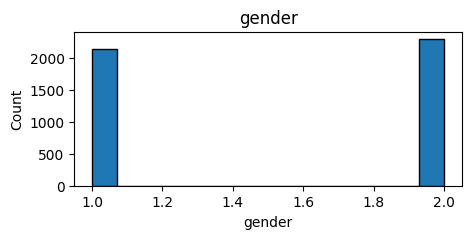

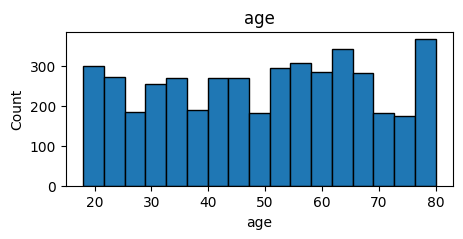

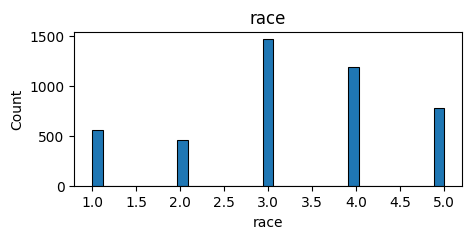

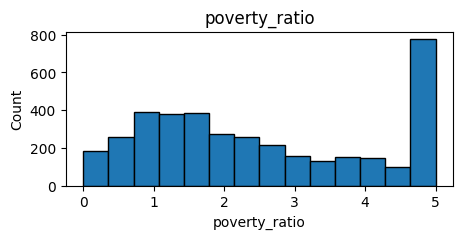

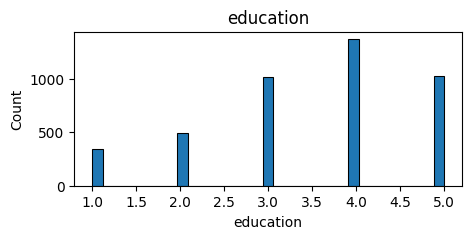

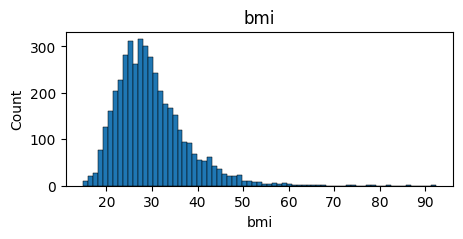

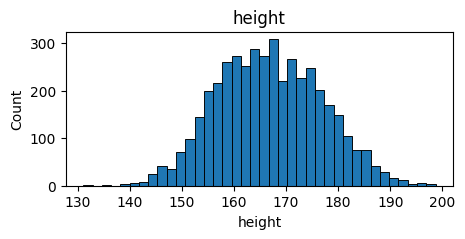

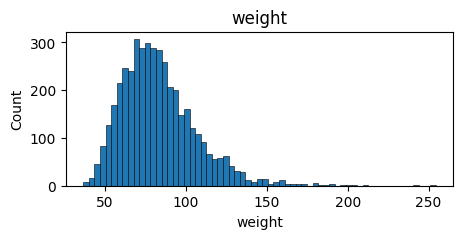

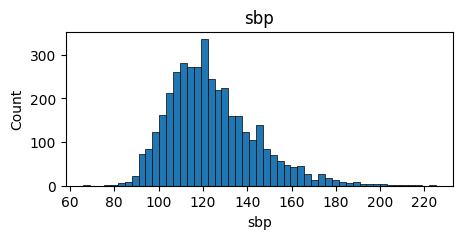

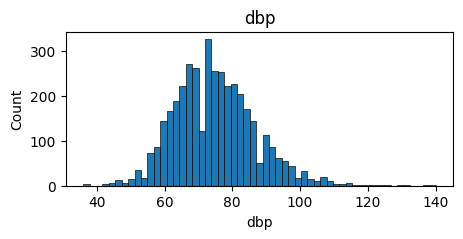

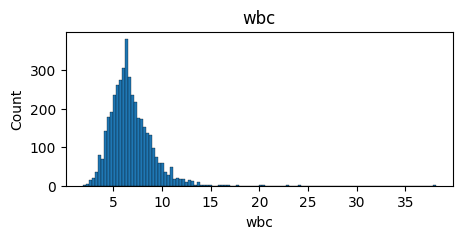

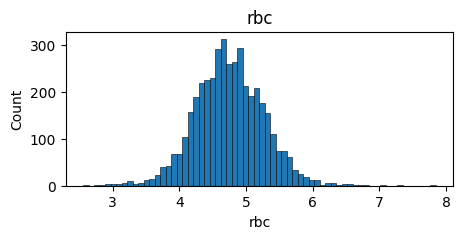

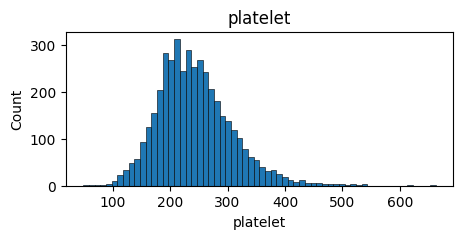

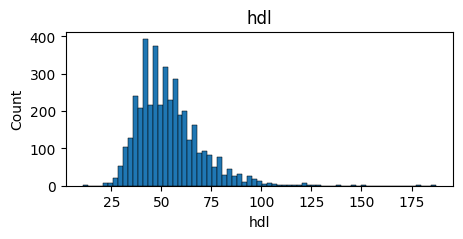

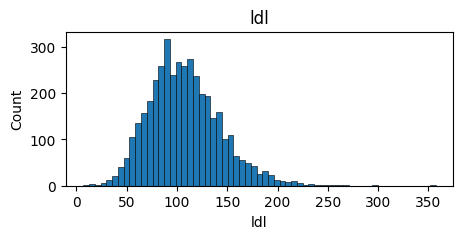

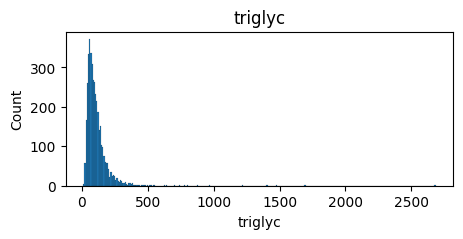

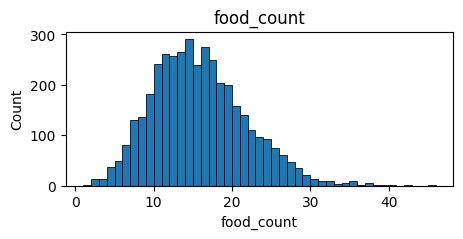

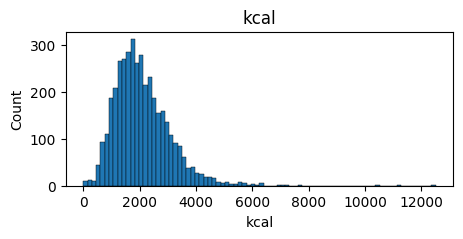

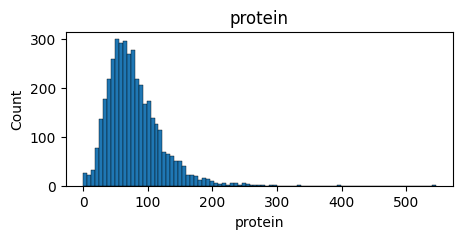

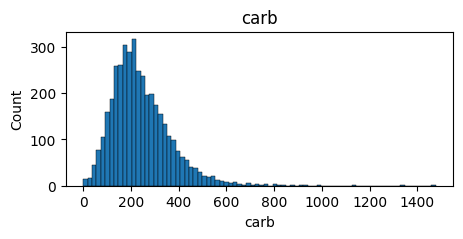

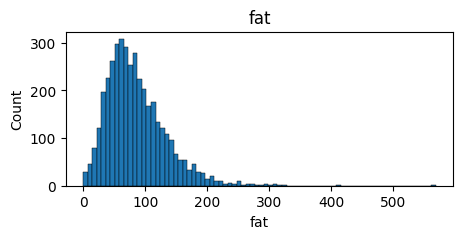

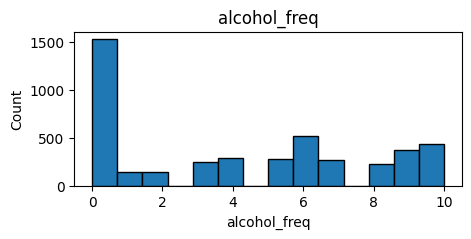

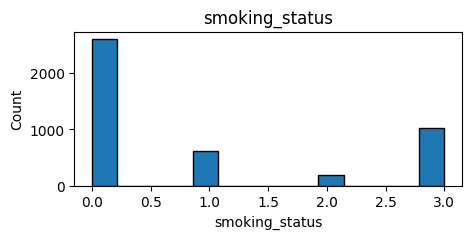

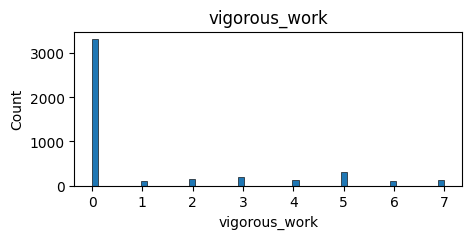

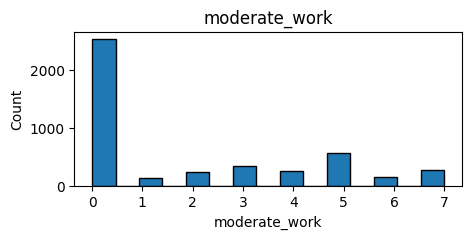

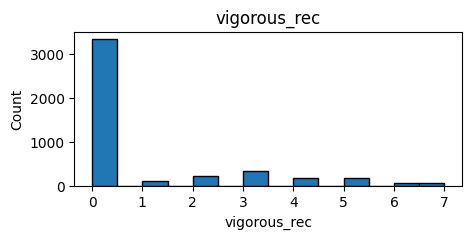

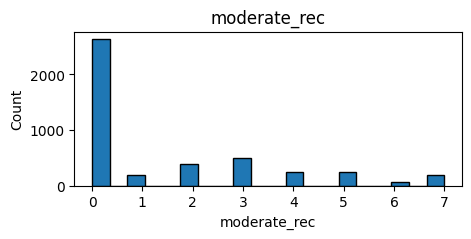

In [11]:
# Generate histograms
for col in df.columns:
  if col != 'seqn':
    plt.figure(figsize=(5,2))
    plt.title(col)
    sns.histplot(df[col], alpha=1)
    plt.show()

After reviewing the histograms, I decided to drop the 'race' column.
While this could be a valuable demographic variable, it does not follow any ordinal logic, making it difficult to utilize in a k-means model. I could have used one-hot encoding, however, because k-means clustering relies on distance between data points, introducing binary columns for each category would likely not have benefited the model.

**Note:** When I first completed this project, I decided to keep the 'gender' variable because, while it is a nominal categorical variable, similar to 'race', it is binary in this dataset, and would therefore not require one-hot encoding. However, after running the model, I found that the clusters were consistently split between the two gender values. This didn't provide much meaningful insight, so I decided to remove it at this stage of the project.

In [12]:
# Remove nominal categorical variables
df = df.drop(columns=['race','gender'])

## Imputation

While many of the variables display a fairly normal distribution, most of them have some significant outliers, so I imputed all null values with column medians.

In [13]:
# Impute null values
imputer = SimpleImputer(strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [14]:
# Confirm that all nulls have been addressed
sum(df.isnull().sum())

0

## Feature Engineering

Before building the clustering models, I created additional features by combining some of the existing variables. This reduced the dimensionality of the model, helping the model avoid unnecessary complexities.

In [15]:
# Features that consolidate physical activity variables
df['total_phy_act'] = df['vigorous_work'] + df['moderate_work'] + df['vigorous_rec'] + df['moderate_rec']
df['total_work_act'] = df['vigorous_work'] + df['moderate_work']
df['total_rec_act'] = df['vigorous_rec'] + df['moderate_rec']
df['total_vigorous_act'] = df['vigorous_work'] + df['vigorous_rec']
df['total_moderate_act'] = df['moderate_work'] + df['moderate_rec']

# Feature to consolidate cardiovascular measures (scale the individual measures first so they are evenly weighted)
scaler = StandardScaler()
cardio = df[['sbp','dbp','hdl','ldl','triglyc']]
cardio_scaled = pd.DataFrame(scaler.fit_transform(cardio), columns=cardio.columns)
df['cardio_index'] = cardio_scaled['sbp'] + cardio_scaled['dbp'] - cardio_scaled['hdl'] + cardio_scaled['ldl'] + cardio_scaled['triglyc']

In [16]:
# View statistical summary again, with the new features added
df.describe().round(2)

,seqn,age,poverty_ratio,education,bmi,height,weight,sbp,dbp,wbc,rbc,platelet,hdl,ldl,triglyc,food_count,kcal,protein,carb,fat,alcohol_freq,smoking_status,vigorous_work,moderate_work,vigorous_rec,moderate_rec,total_phy_act,total_work_act,total_rec_act,total_vigorous_act,total_moderate_act,protein_kcal,carb_kcal,fat_kcal,phy_act_kcal,cardio_index
count,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00
mean,117186.32,49.63,2.50,3.54,29.79,166.81,83.15,123.76,74.71,6.76,4.75,242.35,53.61,107.46,106.71,15.29,2084.23,77.94,240.61,84.78,4.09,0.92,1.03,1.82,0.83,1.42,5.11,2.85,2.25,1.86,3.24,0.04,0.12,0.04,0.00,-0.00
std,4498.48,18.29,1.50,1.18,7.64,9.93,23.14,18.78,11.31,2.07,0.51,63.47,15.35,34.04,89.97,5.75,944.49,39.50,118.87,45.44,3.67,1.24,2.00,2.39,1.65,2.04,5.12,3.80,3.03,2.69,3.32,0.01,0.03,0.01,0.04,2.81
min,109271.00,18.00,0.00,1.00,14.90,131.10,36.70,66.00,36.00,1.90,2.56,49.00,11.00,7.00,10.00,1.00,3.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-10.27
25%,113333.25,34.00,1.33,3.00,24.70,159.50,67.10,111.00,67.00,5.40,4.43,200.00,43.00,85.00,61.00,11.00,1467.50,52.46,165.06,54.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.10,0.03,0.00,-1.87
50%,117247.00,51.00,2.19,4.00,28.50,166.50,79.80,121.00,74.00,6.50,4.73,235.00,51.00,104.00,88.00,15.00,1951.00,71.47,220.23,77.18,4.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,3.00,0.04,0.11,0.04,0.00,-0.17
75%,121077.75,64.00,3.70,4.00,33.50,173.90,94.80,133.00,81.00,7.80,5.06,276.00,61.00,126.00,126.00,18.00,2533.75,96.10,295.48,106.33,7.00,2.00,1.00,4.00,0.00,3.00,8.00,5.00,4.00,3.00,5.00,0.04,0.13,0.05,0.00,1.73
max,124822.00,80.00,5.00,5.00,92.30,198.70,254.30,225.00,140.00,38.10,7.84,662.00,187.00,357.00,2684.00,46.00,12501.00,545.20,1476.76,567.96,10.00,3.00,7.00,7.00,7.00,7.00,28.00,14.00,14.00,14.00,14.00,0.14,0.37,0.08,2.67,28.54


## Scaling

To give each feature a similar weight in the model, I scaled each column in the dataframe.

In [17]:
# Scale data
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.describe().round(2)

,seqn,age,poverty_ratio,education,bmi,height,weight,sbp,dbp,wbc,rbc,platelet,hdl,ldl,triglyc,food_count,kcal,protein,carb,fat,alcohol_freq,smoking_status,vigorous_work,moderate_work,vigorous_rec,moderate_rec,total_phy_act,total_work_act,total_rec_act,total_vigorous_act,total_moderate_act,protein_kcal,carb_kcal,fat_kcal,phy_act_kcal,cardio_index
count,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00,4438.00
mean,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.76,-1.73,-1.67,-2.15,-1.95,-3.60,-2.01,-3.08,-3.42,-2.35,-4.33,-3.05,-2.78,-2.95,-1.08,-2.48,-2.20,-1.97,-2.02,-1.87,-1.12,-0.74,-0.52,-0.76,-0.50,-0.69,-1.00,-0.75,-0.74,-0.69,-0.98,-3.04,-4.15,-3.99,-0.09,-3.65
25%,-0.86,-0.85,-0.78,-0.46,-0.67,-0.74,-0.69,-0.68,-0.68,-0.66,-0.63,-0.67,-0.69,-0.66,-0.51,-0.75,-0.65,-0.65,-0.64,-0.66,-1.12,-0.74,-0.52,-0.76,-0.50,-0.69,-1.00,-0.75,-0.74,-0.69,-0.98,-0.61,-0.58,-0.56,-0.09,-0.67
50%,0.01,0.07,-0.21,0.39,-0.17,-0.03,-0.14,-0.15,-0.06,-0.13,-0.03,-0.12,-0.17,-0.10,-0.21,-0.05,-0.14,-0.16,-0.17,-0.17,-0.03,-0.74,-0.52,-0.76,-0.50,-0.69,-0.22,-0.75,-0.74,-0.69,-0.07,-0.12,-0.14,-0.06,-0.04,-0.06
75%,0.87,0.79,0.80,0.39,0.49,0.71,0.50,0.49,0.56,0.50,0.62,0.53,0.48,0.54,0.21,0.47,0.48,0.46,0.46,0.47,0.79,0.87,-0.02,0.91,-0.50,0.77,0.57,0.56,0.58,0.42,0.53,0.45,0.58,0.62,0.01,0.62
max,1.70,1.66,1.66,1.23,8.18,3.21,7.40,5.39,5.77,15.13,6.12,6.61,8.69,7.33,28.65,5.34,11.03,11.83,10.40,10.63,1.61,1.68,2.98,2.17,3.73,2.73,4.48,2.93,3.88,4.50,3.24,7.78,8.86,3.86,64.84,10.15


# k-means Models

## Defining functions

To avoid repeating code for each model, I defined some functions to quickly create k-means models and visualizations.

First, a function to help determine the optimal k value (number of clusters) for a given list of features:

In [18]:
# Generate line plots to help determine optimal k value
def optimal_k(features):

  # Create dataframe that only contains features
  X = df_scaled[features].copy()

  # Determine optimal k value using elbow method
  inertia = []
  K = range(1, 11)
  for k in K:
      kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
      kmeans.fit(X)
      inertia.append(kmeans.inertia_)

  # Determine optimal k value using silhouette scores
  silhouette_scores = []
  for k in K[1:]:
      kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
      labels = kmeans.fit_predict(X)
      score = silhouette_score(X, labels)
      silhouette_scores.append(score)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

  # Plot for elbow method
  sns.lineplot(x=K, y=inertia, marker='o', ax=ax1)
  ax1.set_xlabel('Number of Clusters (k)')
  ax1.set_ylabel('Inertia')
  ax1.set_title('Elbow Method')
  ax1.set_xticks(K)

  # Plot for silhouette scores
  sns.lineplot(x=K[1:], y=silhouette_scores, marker='o', ax=ax2)
  ax2.set_xlabel('Number of Clusters (k)')
  ax2.set_ylabel('Silhouette Score')
  ax2.set_title('Silhouette Scores')
  ax2.set_xticks(K[1:])

  plt.tight_layout()
  plt.show()

And second, a function that defines a k-means model, fits it to the specified features, and generates a statistical summary and visualizations of the clusters:

In [19]:
# Build the model with a specified k value
def run_model(k, features):

  # Define the features
  X = df_scaled[features].copy()
  kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
  clusters = kmeans.fit_predict(X)

  # Add cluster labels to dataframes
  X['cluster'] = clusters
  df['cluster'] = clusters

  # Display a summary of the clusters
  cluster_cols = ['cluster'] + features
  cluster_summary = df[cluster_cols].groupby('cluster').mean()
  cluster_counts = df['cluster'].value_counts()
  cluster_summary['count'] = cluster_summary.index.map(cluster_counts)
  print(cluster_summary.round(2))

  # Pair plot
  sns.pairplot(df[cluster_cols], hue='cluster', palette='deep')
  plt.show()

  # 3D scatter plot, if more than 2 features (first 3 variables in 'features' list will be used as x, y and z)
  if len(features) > 2:
    fig = plt.figure(figsize=(15, 8))
    ax = plt.axes(projection='3d')
    scatter = ax.scatter(
        df[features[0]],
        df[features[1]],
        df[features[2]],
        c=df['cluster'],
        cmap='viridis',
        s=50)
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(features[2])
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    plt.show()

## Demographic clusters

First, I created a simple 2-dimensional model using only demographic features:
- age
- poverty_ratio

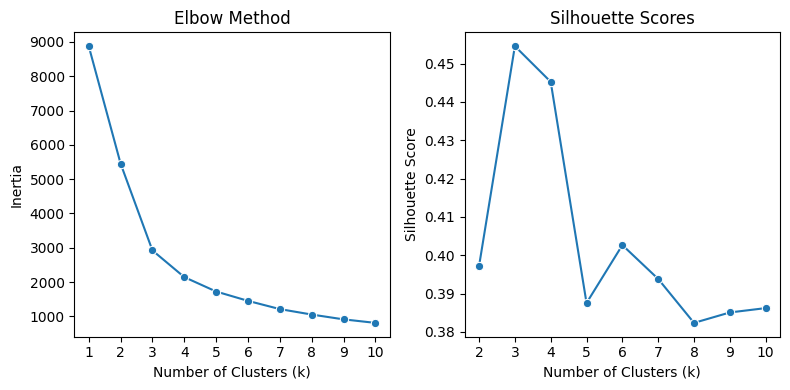

In [20]:
# Determine k value
feature_list = ['age', 'poverty_ratio']
optimal_k(feature_list)

Both the elbow method and silhouette scores indicate that a k value of 3 would be optimal for these two features.

           age  poverty_ratio  count
cluster                             
0        31.83           1.65   1546
1        65.00           1.76   1671
2        51.14           4.60   1221


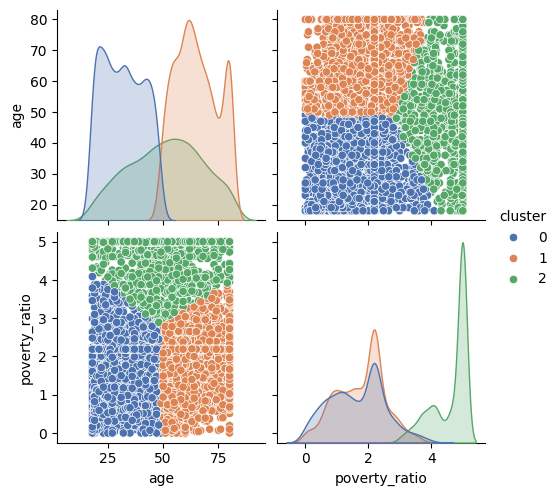

In [21]:
# Run the model and generate visualizations
run_model(3, feature_list)

Since these clusters are 2-dimensional, it's very easy to visualize and see how they were partitioned on a simple x-y plot.

The survey respondents in these clusters could be described as:
- <u>Cluster 0</u>: Younger with low to mid-range income
- <u>Cluster 1</u>: Older with low to mid-range income
- <u>Cluster 2</u>: Higher income, spanning all ages

After this initial model, I ran it again, but with an additional dimension added. Features:
- age
- poverty_ratio
- education

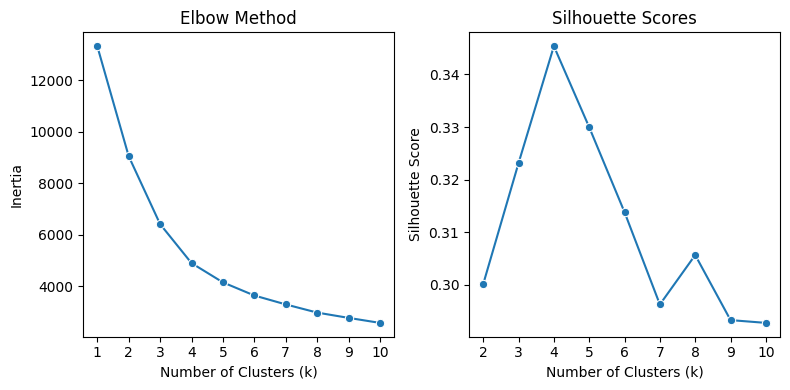

In [22]:
# Determine k value
feature_list = ['age', 'poverty_ratio', 'education']
optimal_k(feature_list)

With an additional feature added, a k value of 4 would be optimal.

           age  poverty_ratio  education  count
cluster                                        
0        64.52           1.90       3.77   1256
1        57.33           1.67       1.54    757
2        30.12           1.68       3.74   1282
3        50.05           4.64       4.41   1143


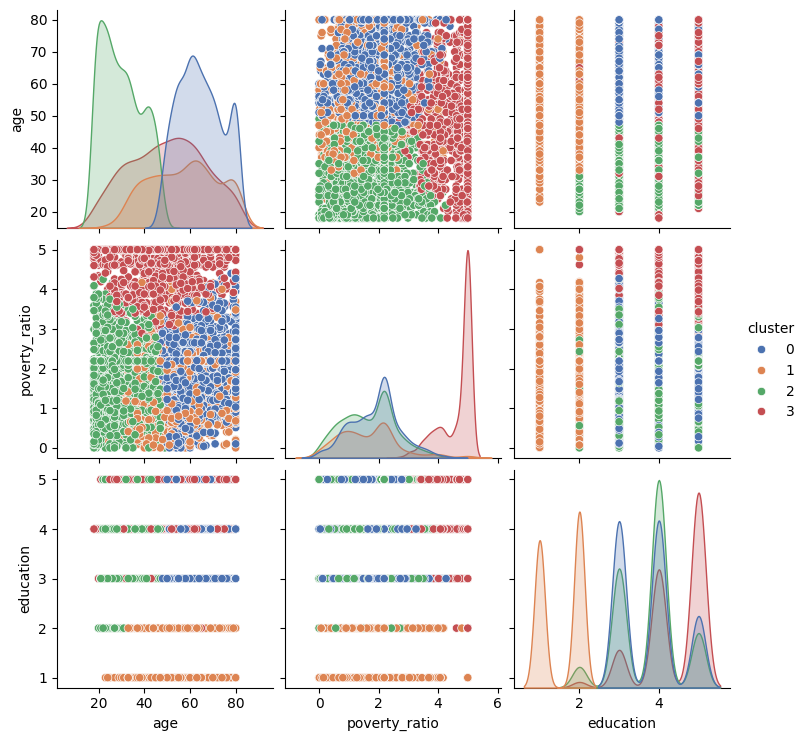

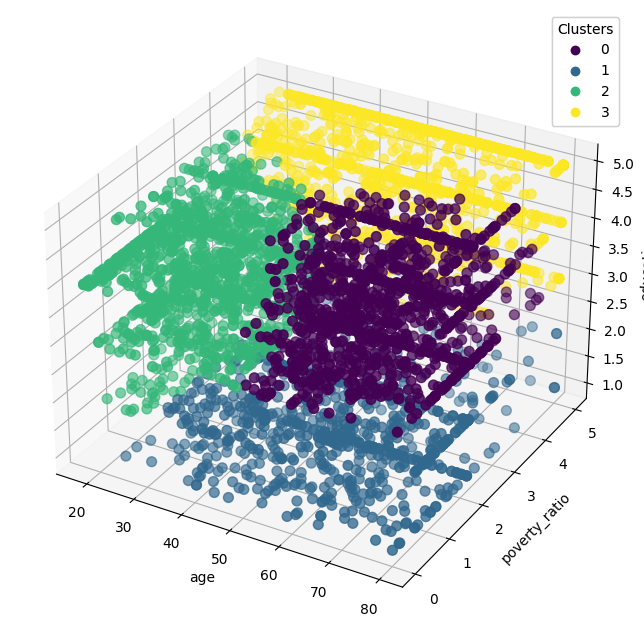

In [23]:
# Run the model and generate visualizations (since this model includes 3 dimensions, a 3D scatter plot will also be generated)
run_model(4, feature_list)

By adding an additional feature, it appears that the model created three clusters (0, 2, 3) with characteristics similar to the previous model. However, a fourth cluster (1) was identified, which groups many of the survey respondents with lower levels of education.

- <u>Cluster 0</u>: Older with low to mid-range income and higher education level
- <u>Cluster 1</u>: Low to mid range income and lower education levels
- <u>Cluster 2</u>: Younger with low to mid-range income and higher education levels
- <u>Cluster 3</u>: Higher income and education levels, spanning all ages

## Physical activity, caloric intake, and BMI clusters

To cluster the data by physical activity, caloric intake, and BMI, I used the following features:
- total_phy_act
- kcal
- bmi

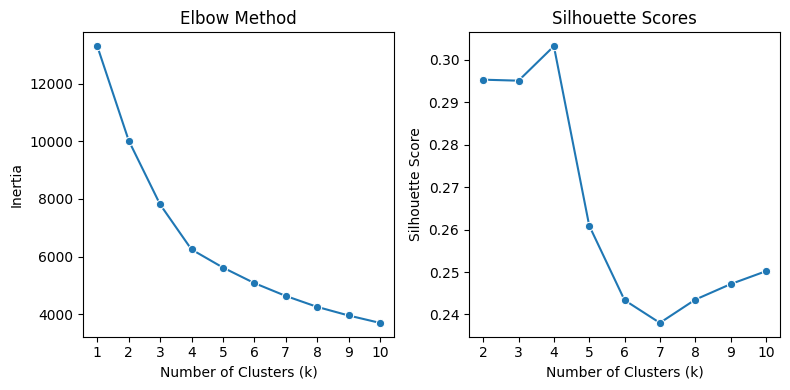

In [24]:
# Determine k value
feature_list = ['total_phy_act', 'kcal', 'bmi']
optimal_k(feature_list)

Both the elbow method and silhouette scores suggest a k value of 4 would be appropriate.

         total_phy_act     kcal    bmi  count
cluster                                      
0                 2.31  1706.79  26.47   2031
1                 3.33  1859.50  41.78    752
2                12.30  1957.53  28.03    958
3                 5.30  3600.70  28.92    697


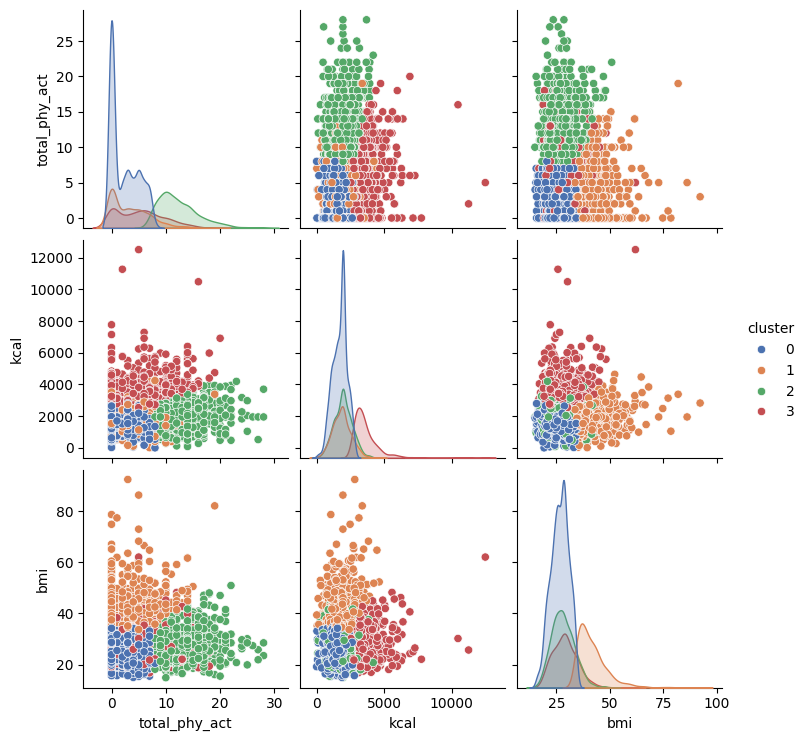

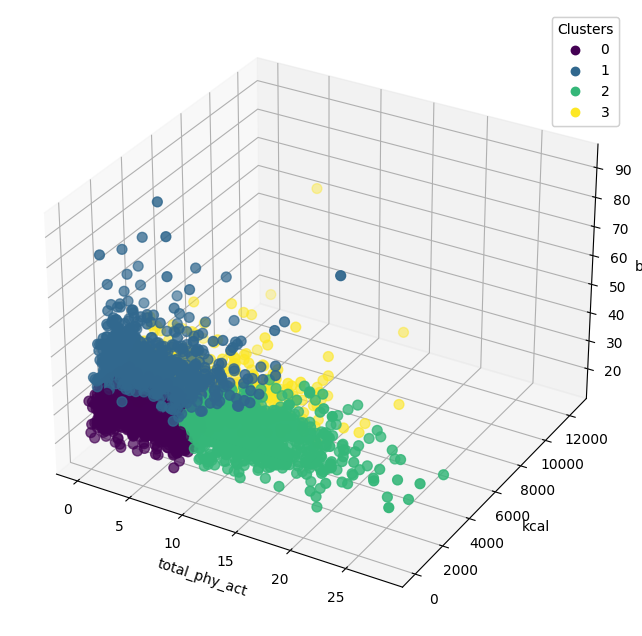

In [25]:
# Run the model and generate visualizations
run_model(4, feature_list)

Approximately 45% of the survey respondents belong to cluster 0, which is characterized by low values in all three of the features. Each of the other three clusters is mostly characterized by a relatively high value in one of the three features.

- <u>Cluster 0</u>: Low values in all three variables
- <u>Cluster 1</u>: High BMI
- <u>Cluster 2</u>: High level of physical activity
- <u>Cluster 3</u>: High caloric intake

## Age and physical activity clusters

To cluster the data based on age and the two type of physical activity, I used the following features:

- age
- total_vigorous_act
- total_moderate_act

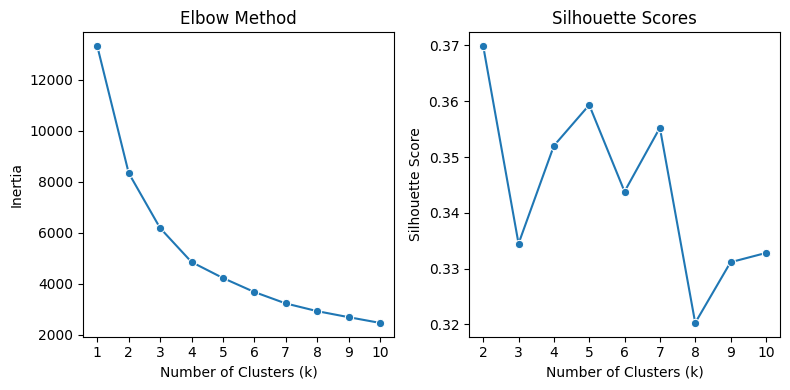

In [26]:
# Determine k value
feature_list = ['age', 'total_vigorous_act', 'total_moderate_act']
optimal_k(feature_list)

While the silhouette values didn't indicate an obvious ideal k value, the elbow method line graph shows the 4 would be an appropriate value.

           age  total_vigorous_act  total_moderate_act  count
cluster                                                      
0        56.94                0.89                6.83    796
1        65.82                0.40                0.78   1516
2        33.07                1.14                1.73   1241
3        38.54                6.27                6.35    885


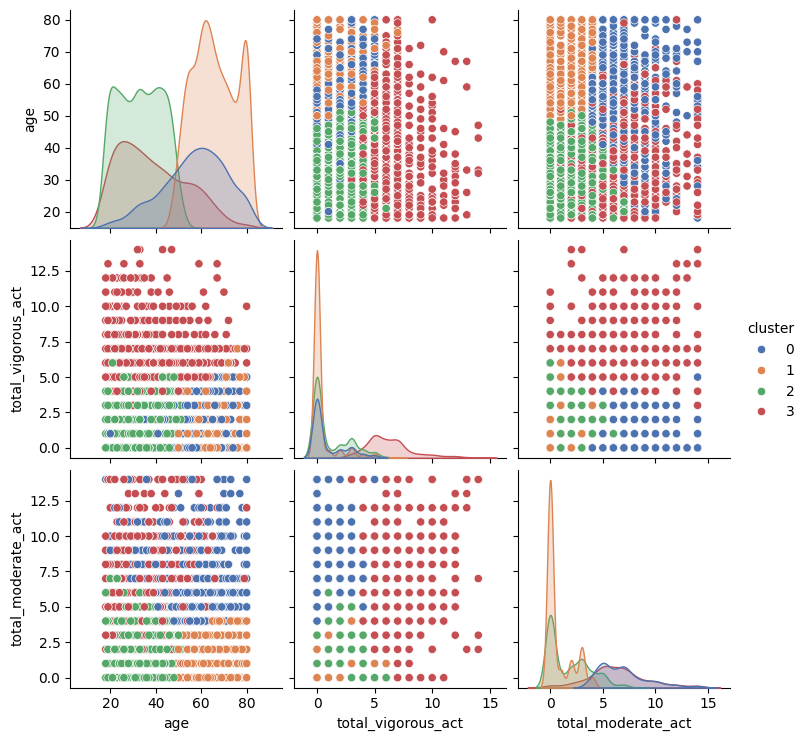

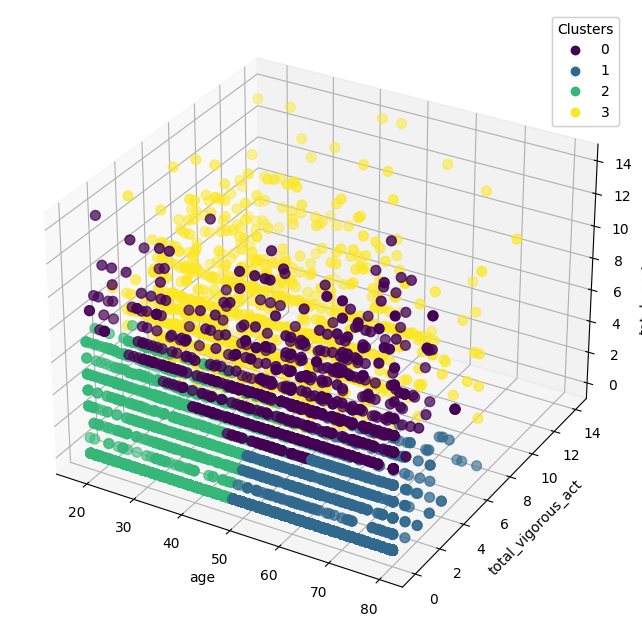

In [27]:
# Run the model and generate visualizations
run_model(4, feature_list)

Approximately 62% of the respondents belong to clusters 1 and 2, which are characterized by low physical activity levels and are fairly evenly partitioned by age. The other two clusters have higher physical activity levels and are also partitioned by age, however with significantly more age overlap than clusters 1 and 2.

- <u>Cluster 0</u>: Older with higher levels of moderate physical activity (but not high levels of vigorous physical activity)
- <u>Cluster 1</u>: Older with low physical activity levels (both moderate and vigorous)
- <u>Cluster 2</u>: Younger with low physical activity levels (both moderate and vigorous)
- <u>Cluster 3</u>: Younger with higher levels of total physical activity (both moderate and vigorous)

## Cardio health, smoking status, and age clusters

Lastly, I used the cardiovascular index that I created while feature engineering to see how the data was clustered when smoking status and age were also included as features:
- cardio_index
- smoking_status
- age

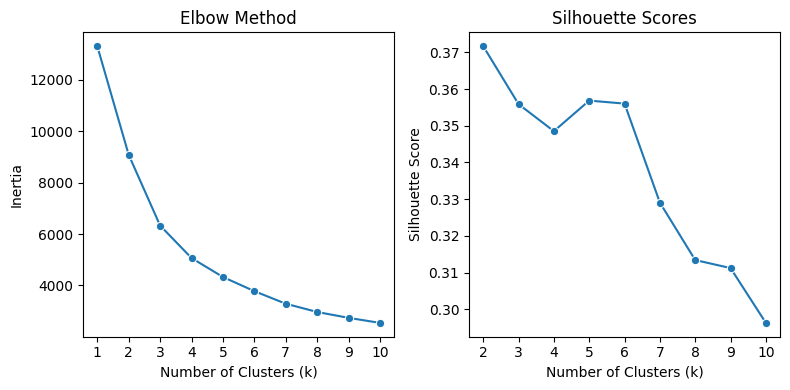

In [28]:
# Determine k value
feature_list = ['cardio_index', 'smoking_status', 'age']
optimal_k(feature_list)

The elbow method and silhouette scores show that 3 would be an appropriate k value for this model.

         cardio_index  smoking_status    age  count
cluster                                            
0                0.35            2.88  57.52   1152
1               -1.63            0.24  30.97   1472
2                1.10            0.22  59.76   1814


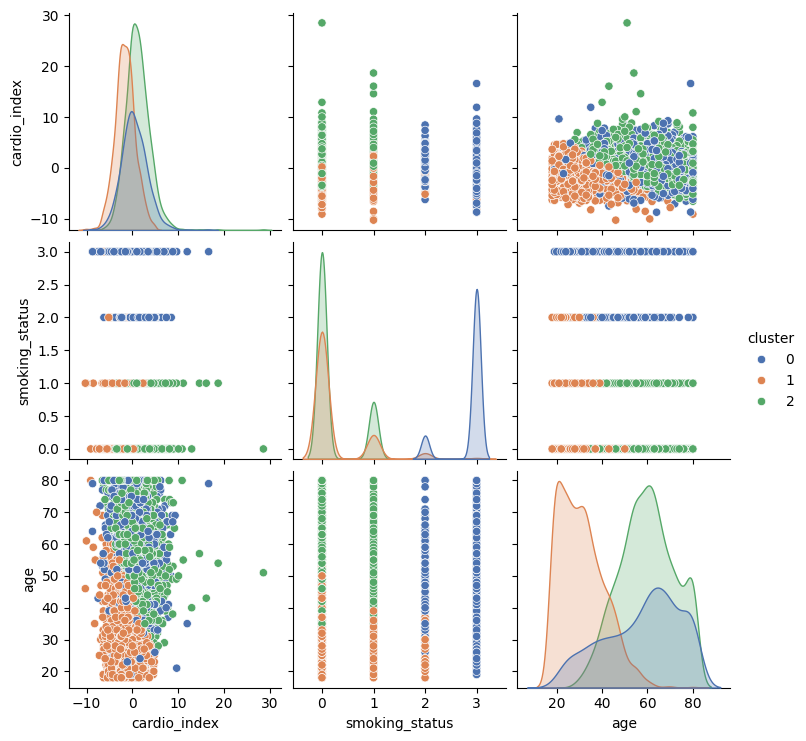

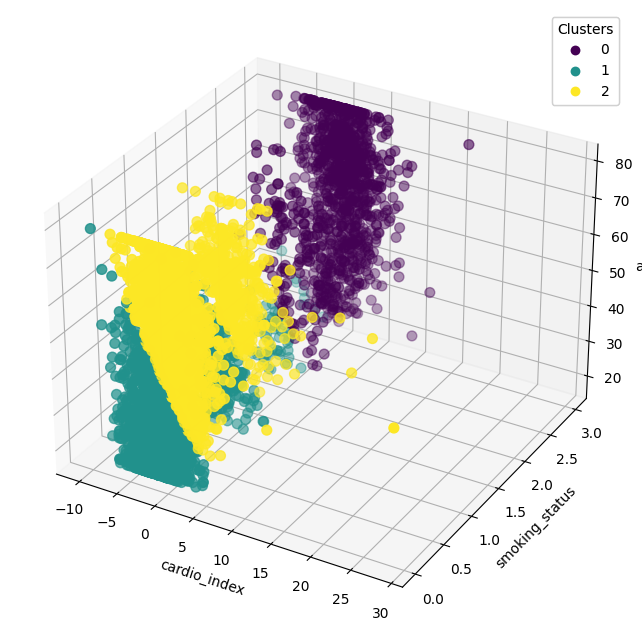

In [29]:
# Run the model and generate visualizations
run_model(3, feature_list)

Cluster 0 captures individuals with higher smoking status scores (indicating more frequent smoking), and a wide distribution of cardio index and age. The other two clusters can be characterized as mostly non-smokers and were generally partitioned between older respondents with high cardio indexes (indicating higher-risk cardiovascular health) and younger respondents with lower cardio indexes (indicating lower-risk cardiovascular health).

- <u>Cluster 0</u>: Smokers, spanning all cardio risk levels and ages (although, more older respondents than young)
- <u>Cluster 1</u>: Younger non-smokers, low-risk cardio
- <u>Cluster 2</u>: Older non-smokers, high-risk cardio